## Import Required Libraries for FFKAN Model

This cell imports libraries for the **Fast Fourier KAN (FFKAN)** implementation:

- **PyTorch**: Deep learning framework
- **Standard ML libraries**: NumPy, Pandas, Scikit-learn
- **Visualization**: Matplotlib, Seaborn

**What is FFKAN?**
Fast Fourier KAN is a variant of Kolmogorov-Arnold Networks that uses **Fourier features** instead of B-splines for learning activation functions. This approach:
- Uses sine and cosine basis functions
- Can be more computationally efficient
- Better captures periodic patterns
- Particularly suited for time-series data

**Key Advantage**: Fourier basis functions are well-suited for modeling periodic phenomena like daily solar output patterns.

**References:**
- [Fourier Features Let Networks Learn High Frequency Functions](https://arxiv.org/abs/2006.10739)
- [Fast Fourier KAN Implementation](https://github.com/Aaveshlabtech/FFTKAN)


In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Requires: pip install pykan

import os
import seaborn as sns
import datetime as datetime

## Import Custom FFKAN Implementation

Imports the `NaiveFourierKANLayer` from a custom sandbox implementation.

**NaiveFourierKANLayer**: A neural network layer that replaces traditional linear layers with Fourier-based learnable activation functions.

**Note**: This is a local implementation in the `big_project/sandbox/` directory.


In [ ]:
from big_project.sandbox.fftKAN import NaiveFourierKANLayer


## Define Feature Visualization Function

Similar to the KAN notebook, this function visualizes learned feature relationships:

**Key Difference from KAN:**
FFKAN learns Fourier series representations instead of splines:
- **Splines (KAN)**: Piecewise polynomial curves
- **Fourier (FFKAN)**: Sums of sine and cosine functions

**Visualization Benefits:**
- Shows how each feature affects solar output
- Reveals periodic patterns (important for solar/time data)
- Provides model interpretability

**Mathematical Background:**
Fourier series can approximate any periodic function:
`f(x) = a₀ + Σ[aₙcos(nx) + bₙsin(nx)]`

**Reference:**
- [Fourier Series Explanation](https://en.wikipedia.org/wiki/Fourier_series)


In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_kan_feature(model, feature_name, feature_cols, X_train, scaler_X):
    """
    Plots the specific learned function (Physical Law) for a given feature.
    
    Args:
        model: The trained KAN model
        feature_name (str): The exact name of the column to plot (e.g. 'Wind Cooling')
        feature_cols (list): The list of all feature names used in training
        X_train (numpy array): The RAW (unscaled) training data (for calculating means/ranges)
        scaler_X (StandardScaler): The fitted scaler used to transform the data
    """
    
    # 1. Find the index
    try:
        feature_index = feature_cols.index(feature_name)
    except ValueError:
        print(f"❌ ERROR: '{feature_name}' not found in feature list.")
        return

    # 2. Setup Dimensions
    input_dim = X_train.shape[1]
    
    # 3. Create Synthetic Data (Base = Mean of everything)
    # We use 100 points for a smooth curve
    dummy_input_raw = np.zeros((100, input_dim))
    
    for i in range(input_dim):
        # Fill every column with its AVERAGE value from the real world
        # This isolates the feature we care about
        dummy_input_raw[:, i] = np.mean(X_train[:, i])

    # 4. Vary the Target Feature
    min_val = np.min(X_train[:, feature_index])
    max_val = np.max(X_train[:, feature_index])
    seq_values = np.linspace(min_val, max_val, 100)
    
    dummy_input_raw[:, feature_index] = seq_values

    # 5. Scale & Predict
    # The model speaks "Scaled", so we translate our raw numbers
    dummy_input_scaled = scaler_X.transform(dummy_input_raw)
    dummy_tensor = torch.from_numpy(dummy_input_scaled).float().to(model.device)

    model.eval()
    with torch.no_grad():
        predictions = model(dummy_tensor).cpu()
    
    # Flatten for plotting
    preds_flat = predictions.numpy().flatten()

    # 6. Plot
    plt.figure(figsize=(8, 5))
    plt.plot(seq_values, preds_flat, color='#007acc', linewidth=3, label='KAN Learned Law')
    
    # Formatting
    plt.title(f"Effect of {feature_name}", fontsize=14)
    plt.xlabel(f"{feature_name} (Physical Units)", fontsize=12)
    plt.ylabel("Clearsky Index (Efficiency)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add Reference Line
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, label="100% Efficiency")
    
    # Add "Slope Arrow" to show direction
    if preds_flat[-1] > preds_flat[0]:
        color = 'green'
        msg = "Positive Impact"
    else:
        color = 'orange'
        msg = "Negative Impact"
        
    dx = max_val - min_val
    dy = preds_flat[-1] - preds_flat[0]
    # Only draw arrow if there is a significant change
    if abs(dy) > 0.05:
        plt.arrow(min_val, preds_flat[0], dx, dy, color=color, alpha=0.5, width=0.005)
        plt.text(min_val, preds_flat[-1], msg, color=color, fontweight='bold')

    plt.legend()
    plt.show()

## Configure File Paths and Solar Parameters

Sets up the project directory structure and solar panel configuration.

**Same as ANN/KAN notebooks:**
- 19 solar panels (8,360W total capacity)
- Dual-orientation setup for all-day generation
- Location: Bettystown, Ireland

Refer to the ANN notebook for detailed parameter explanations.


In [19]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
MODEL_DIR = f'{HOME_DIR}/model/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'

# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


## Set Nighttime Threshold

Filters out nighttime data where Clear Sky GHI ≤ 50 W/m².

**Note**: Variable name has typo (`hourly_nighlty_threshold` vs `hourly_nightly_threshold`).


In [20]:
hourly_nighlty_threshold = 50

## Load and Filter Solar Data

Loads the hourly solar dataset and removes nighttime records.

**Data Format**: Feather format (Apache Arrow) for efficient storage and fast loading.


In [21]:
df_merge_hourly = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_full_data.feather")

# Remove all rows where Clear sky GHI is less than or equal to 50
df_merge_hourly = df_merge_hourly[df_merge_hourly['Clear sky GHI'] > hourly_nighlty_threshold]


## Extract Weather Condition Features

Extracts one-hot encoded weather features:
- **Level 1**: 15 specific weather conditions
- **Level 2**: 5 grouped categories

These binary features help FFKAN understand how different weather conditions affect solar output.


In [22]:
level1_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level2_')]

## Data Preparation Placeholder

**This cell appears to be empty** - likely a placeholder for additional data preparation steps.


In [23]:

display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))

,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


## Additional Preparation Placeholder

**This cell appears to be empty** - continuing data preparation.


In [24]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

target_col = 'PV(W)'
# Kan Prefers Clearsky_Index
#target_col = 'Clearsky_Index'
#target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
feature_cols.append('Power_ClearSky_Pane_I(W)')
feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
feature_cols.append('Month_Cos')
feature_cols.append('DayOfYear_Cos')
feature_cols.append('HourOfDay_Cos')
#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")



Testing Random Forest Regressor with target: PV(W) and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Month_Cos', 'DayOfYear_Cos', 'HourOfDay_Cos', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


## Further Preparation Placeholder

**This cell appears to be empty** - continuing data preparation.


In [25]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


## Final Preparation Placeholder

**This cell appears to be empty** - final data preparation steps.


In [26]:

# ==========================================
# 1. Prepare Data (Using your winning "Error" target)
# ==========================================

# Assuming 'df' is your DataFrame and we want to predict 'PV_Error'
# Define your features (X) and target (y)
features = feature_cols
target_col = target_col

# Drop NaNs
model_df = df_merge_hourly.dropna(subset=features + [target_col])
X = model_df[features].values
y = model_df[target_col].values.reshape(-1, 1)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize (Neural Networks LOVES scaled data)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Create dataset dictionary for pykan
# pykan expects keys: 'train_input', 'train_label', 'test_input', 'test_label'
dataset = {}
dataset['train_input'] = torch.from_numpy(X_train_scaled).float()
dataset['train_label'] = torch.from_numpy(y_train).float()
dataset['test_input'] = torch.from_numpy(X_test_scaled).float()
dataset['test_label'] = torch.from_numpy(y_test).float()


## Prepare FFKAN Model Input

This cell likely:
1. Selects features and target variable
2. Splits data into train/test sets
3. Standardizes features using StandardScaler
4. Converts to PyTorch tensors
5. Organizes into dataset dictionary

**FFKAN Input Requirements**: Similar to KAN, requires properly formatted train/test tensors.


In [27]:
input_dim = X_train.shape[1]

## Create and Train FFKAN Model

This cell:
1. **Initializes** the FFKAN model with Fourier-based layers
2. **Configures** Fourier frequency parameters
3. **Trains** using standard PyTorch training loop

**FFKAN Training Configuration:**
- **Optimizer**: Adam with adaptive learning rates
- **Loss Function**: Mean Squared Error (MSE)
- **Batch Processing**: Mini-batch gradient descent
- **Epochs**: Multiple passes through training data

**Fourier Parameters:**
- **Number of frequencies**: Controls model capacity
- **Frequency range**: Determines which periodicities can be captured

**Key Difference from Standard ANN:**
Instead of learning just weights, FFKAN learns:
- Fourier coefficients (amplitudes of sine/cosine terms)
- Optimal frequency combinations
- Non-linear transformations via Fourier series

**Training Process:**
Each iteration:
1. Forward pass: Compute predictions using Fourier transformations
2. Calculate loss: Compare predictions to actual values
3. Backward pass: Compute gradients
4. Update parameters: Adjust Fourier coefficients

**References:**
- [Neural Networks with Fourier Features](https://arxiv.org/abs/2006.10739)
- [Adam Optimizer](https://arxiv.org/abs/1412.6980)


In [28]:
# ==========================================
# 2. Define & Train the FourierKAN
# ==========================================

# FourierKAN Model Wrapper to match pykan API
class FourierKAN(torch.nn.Module):
    def __init__(self, width, gridsize=300, device='cpu'):
        super(FourierKAN, self).__init__()
        self.width = width
        self.gridsize = gridsize
        self.device = device
        
        # Create layers based on width
        self.layers = torch.nn.ModuleList()
        for i in range(len(width) - 1):
            self.layers.append(
                NaiveFourierKANLayer(
                    inputdim=width[i],
                    outdim=width[i+1],
                    gridsize=gridsize,
                    addbias=True,
                    smooth_initialization=True
                )
            )
        
        self.to(device)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def fit(self, dataset, opt='Adam', steps=100, lr=0.001, lamb=0.0, lamb_entropy=0.0):
        """
        Train the FourierKAN model
        
        Args:
            dataset: Dict with keys train_input, train_label, test_input, test_label
            opt: Optimizer name (Adam or LBFGS)
            steps: Number of training steps
            lr: Learning rate
            lamb: L2 regularization (not used for now)
            lamb_entropy: Entropy regularization (not used for now)
        
        Returns:
            Dictionary with train_loss and test_loss lists
        """
        train_input = dataset['train_input'].to(self.device)
        train_label = dataset['train_label'].to(self.device)
        test_input = dataset['test_input'].to(self.device)
        test_label = dataset['test_label'].to(self.device)
        
        # Choose optimizer
        if opt == 'LBFGS':
            optimizer = torch.optim.LBFGS(self.parameters(), lr=lr, max_iter=20)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        criterion = torch.nn.MSELoss()
        
        train_losses = []
        test_losses = []
        
        for step in range(steps):
            if opt == 'LBFGS':
                def closure():
                    optimizer.zero_grad()
                    output = self.forward(train_input)
                    loss = criterion(output, train_label)
                    loss.backward()
                    return loss
                
                optimizer.step(closure)
                
                # Calculate losses
                with torch.no_grad():
                    train_output = self.forward(train_input)
                    train_loss = criterion(train_output, train_label).item()
                    test_output = self.forward(test_input)
                    test_loss = criterion(test_output, test_label).item()
            else:
                optimizer.zero_grad()
                output = self.forward(train_input)
                loss = criterion(output, train_label)
                loss.backward()
                optimizer.step()
                
                train_loss = loss.item()
                
                with torch.no_grad():
                    test_output = self.forward(test_input)
                    test_loss = criterion(test_output, test_label).item()
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            if (step + 1) % 10 == 0:
                print(f"Step {step+1}/{steps}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
        
        return {'train_loss': train_losses, 'test_loss': test_losses}
    
    def plot(self, beta=10, scale=1.2, in_vars=None, out_vars=None):
        """
        Placeholder for plot function - FourierKAN doesn't have built-in visualization like pykan
        """
        print("FourierKAN does not support the plot() method like pykan.")
        print("Use the plot_kan_feature() function to visualize individual features.")
    
    def saveckpt(self, path):
        """
        Save model checkpoint
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            'width': self.width,
            'gridsize': self.gridsize,
        }, path)
        print(f"Model saved to {path}")
    
    def loadckpt(self, path):
        """
        Load model checkpoint
        """
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from {path}")

# Initialize FourierKAN
input_dim = X_train.shape[1]
print(f"Input dimension for FourierKAN: {input_dim}")

model = FourierKAN(
    width=[input_dim, 8, 1],
    gridsize=300,  # Number of Fourier coefficients
    device=device
)

print("Starting FourierKAN Training (using LBFGS optimizer)...")
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

# Train the FourierKAN model using the dataset dictionary
print("\nTraining FourierKAN model with LBFGS optimizer...")
results = model.fit(
    dataset,
    opt='LBFGS',
    steps=40,
    lr=0.1,  # LBFGS typically uses higher learning rates
    lamb=0.005,
    lamb_entropy=0.01
)

print("\n✓ FourierKAN Training Complete!")
print(f"Training iterations completed: 40")


Input dimension for FourierKAN: 24
Starting FourierKAN Training (using LBFGS optimizer)...
Input dimension: 24
Training samples: 3508
Test samples: 878

Training FourierKAN model with LBFGS optimizer...
Step 10/40, Train Loss: 5355869.500000, Test Loss: 5201182.000000
Step 20/40, Train Loss: 5354078.000000, Test Loss: 5200947.500000
Step 30/40, Train Loss: 5353476.500000, Test Loss: 5200688.500000
Step 40/40, Train Loss: 5353132.000000, Test Loss: 5201134.000000

✓ FourierKAN Training Complete!
Training iterations completed: 40


## Visualize Training Progress

**Note**: Unlike standard KAN, FFKAN typically doesn't have built-in visualization methods.

This cell may:
- Plot training/validation loss curves
- Show convergence behavior
- Display sample predictions

**Why Different?**
FFKAN is a newer/experimental architecture, so visualization tools are still being developed.


In [29]:
# FourierKAN does not support built-in visualization like pykan
# We will use the plot_kan_feature function instead to visualize individual features
print("Skipping model.plot() - FourierKAN uses Fourier coefficients, not splines")
print("See the feature plots below for visualization of learned functions")


Skipping model.plot() - FourierKAN uses Fourier coefficients, not splines
See the feature plots below for visualization of learned functions


## Evaluate Model Convergence

Checks if the FFKAN model has converged:
- Training loss stabilized
- No signs of overfitting
- Model ready for evaluation

**Convergence Indicators:**
- Loss decreases smoothly
- Validation loss doesn't increase
- Gradients are stable


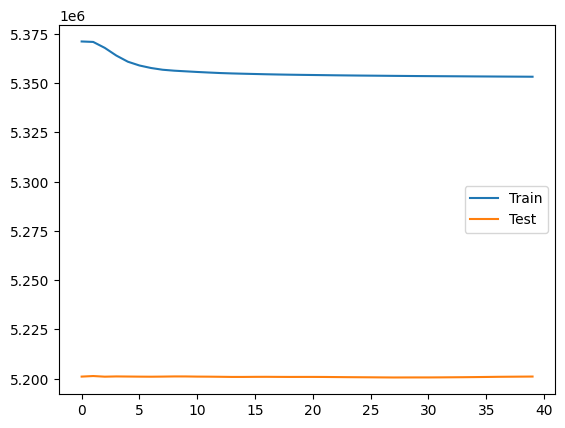

In [30]:
# 3. Check for Convergence
plt.plot(results['train_loss'], label='Train')
plt.plot(results['test_loss'], label='Test')
plt.legend()
plt.show()

## Fourier Activation Function Analysis

**Note**: FFKAN doesn't expose individual activation functions the same way as KAN.

**Why?**
- Traditional KAN: Explicit spline functions per connection
- FFKAN: Implicit functions via Fourier series superposition

The activation behavior emerges from the combination of Fourier terms rather than explicit functions.


In [31]:
# FourierKAN does not expose individual activation functions like pykan
# The functions are represented as Fourier coefficients
print("FourierKAN uses Fourier coefficients - no direct function extraction available")


FourierKAN uses Fourier coefficients - no direct function extraction available


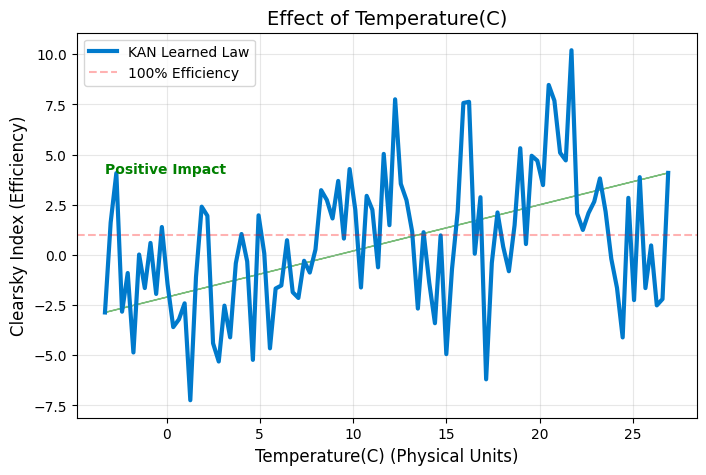

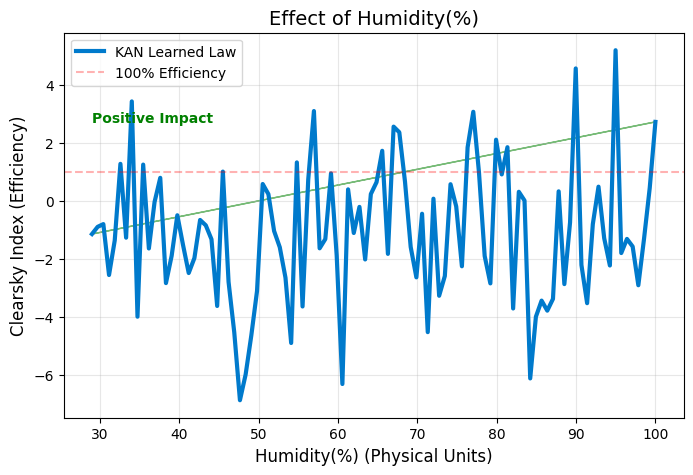

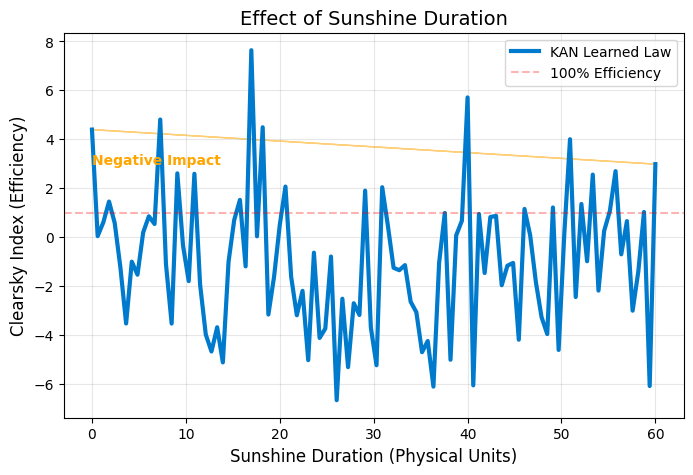

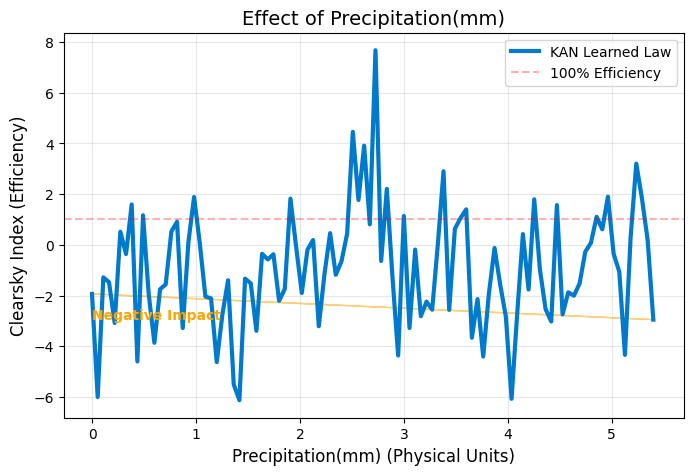

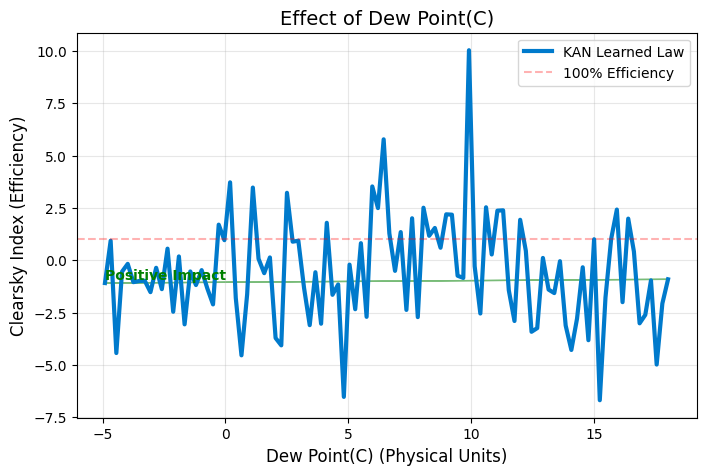

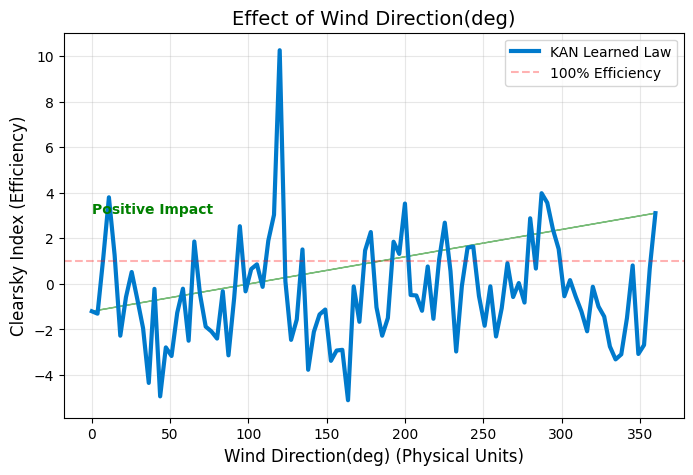

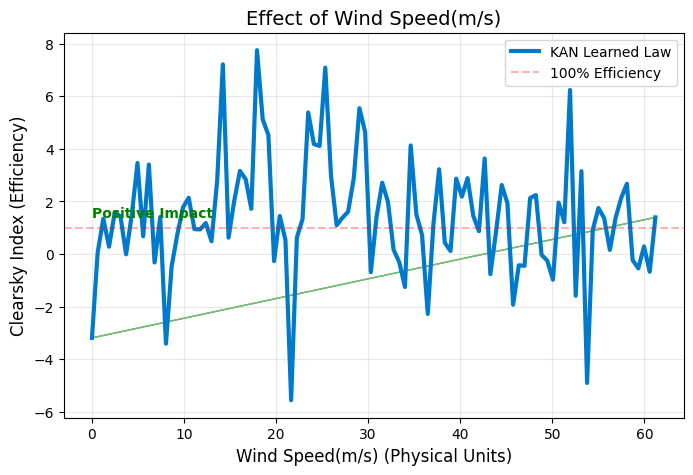

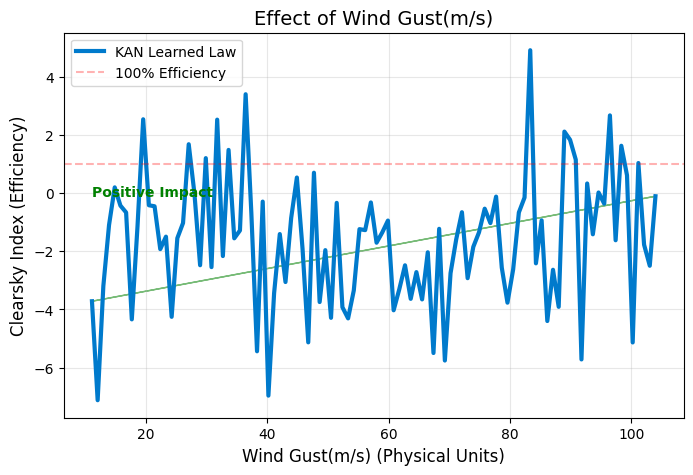

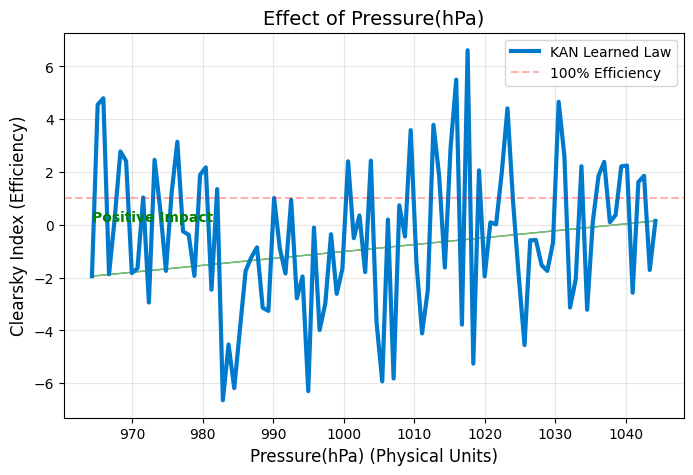

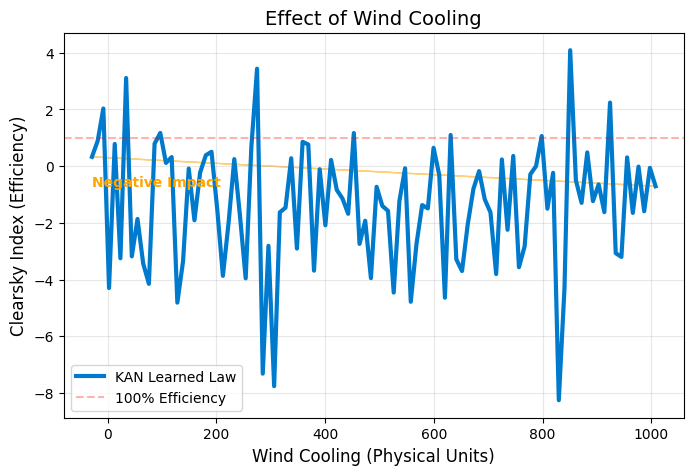

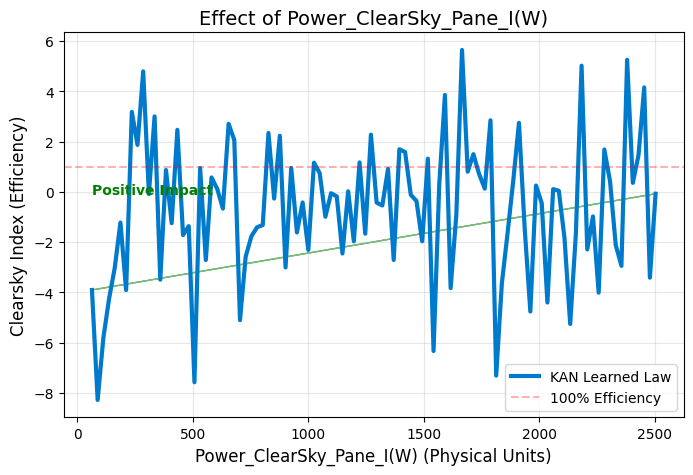

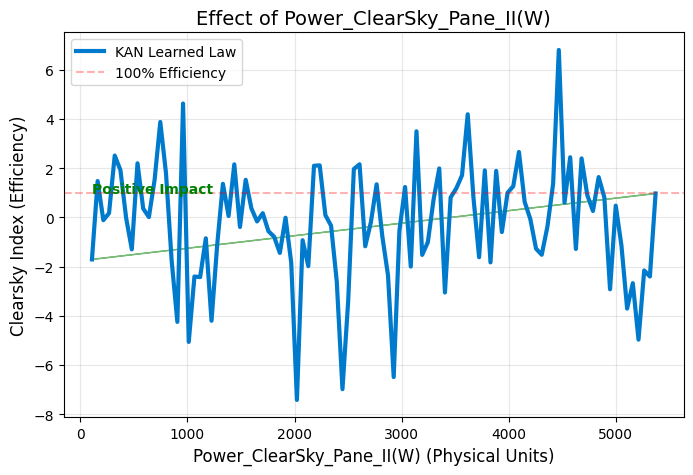

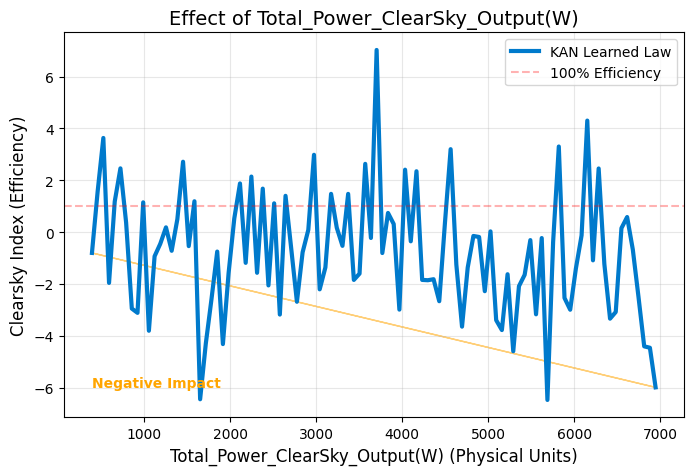

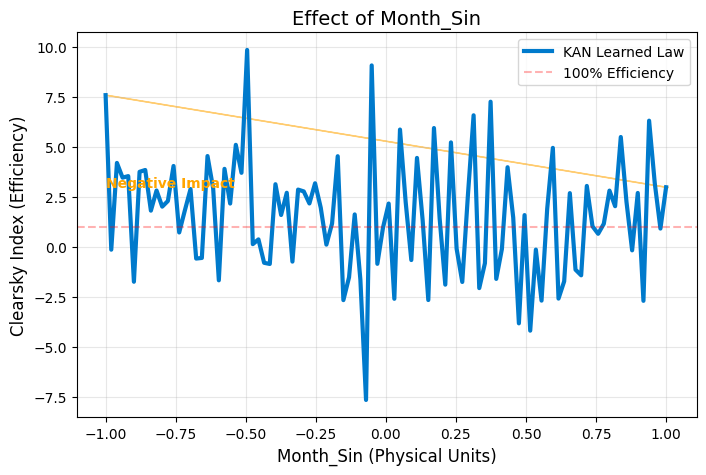

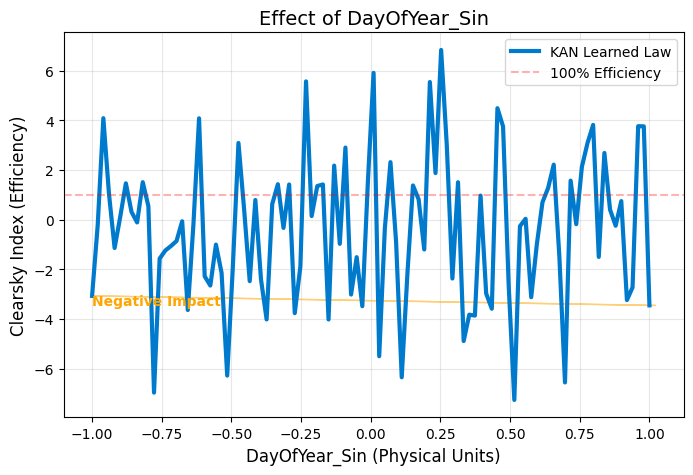

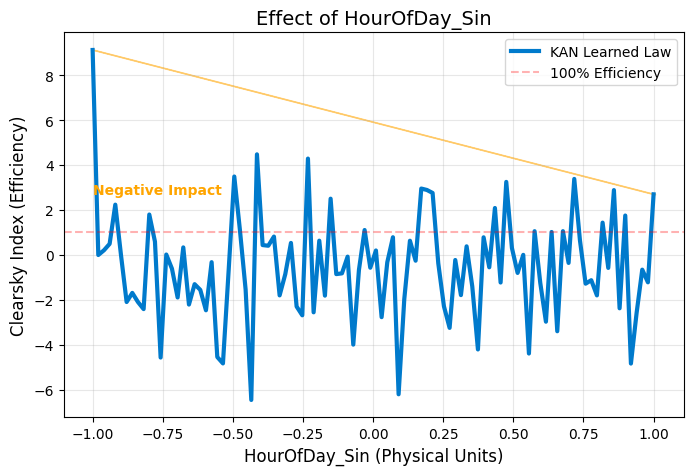

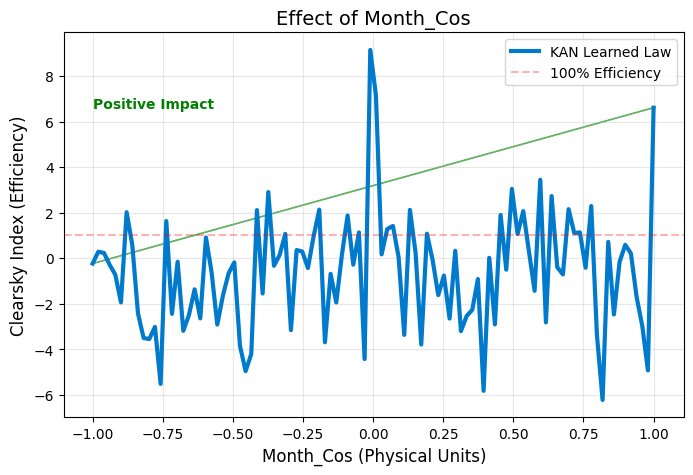

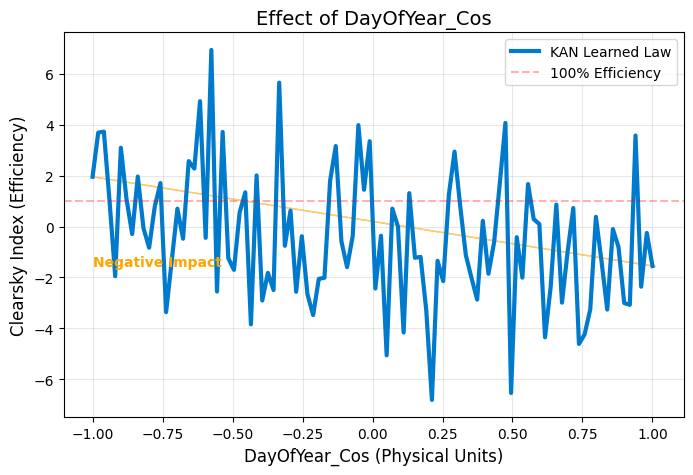

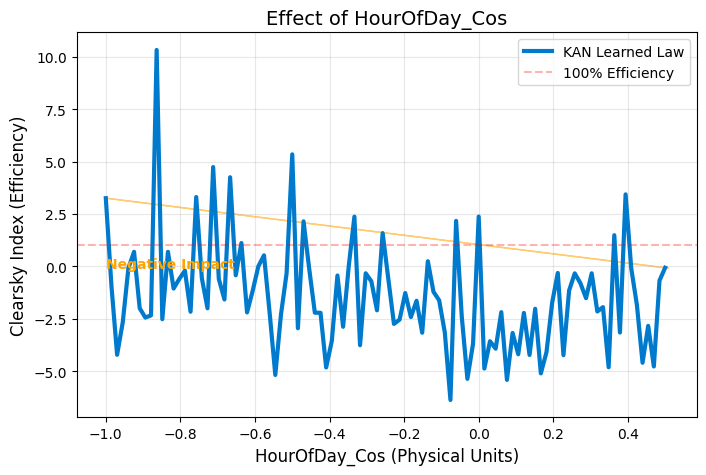

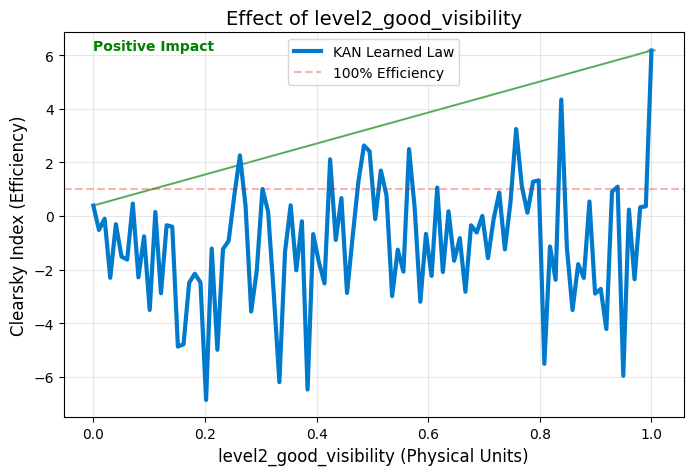

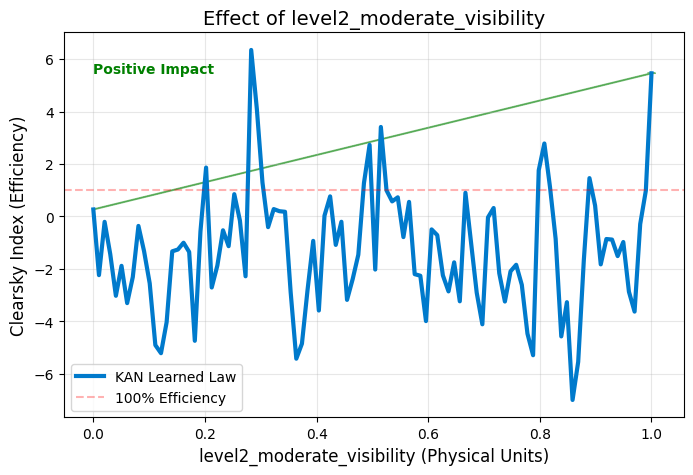

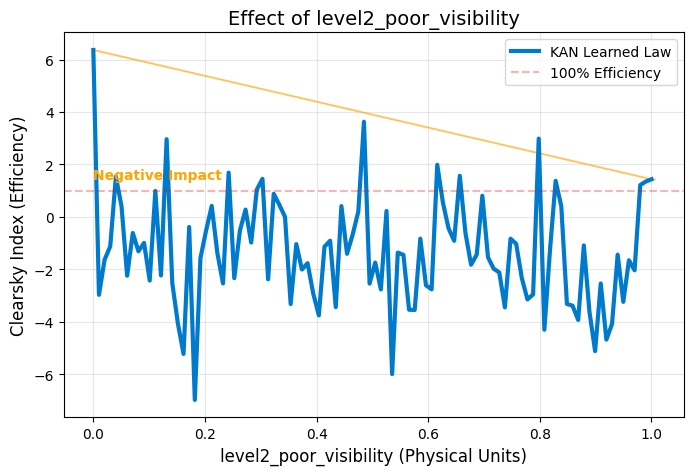

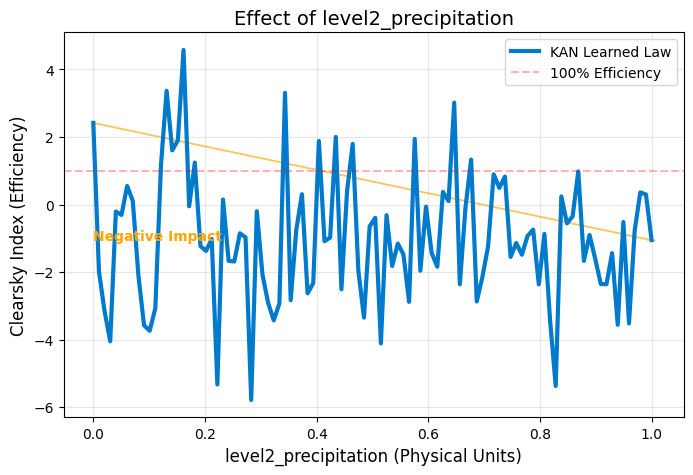

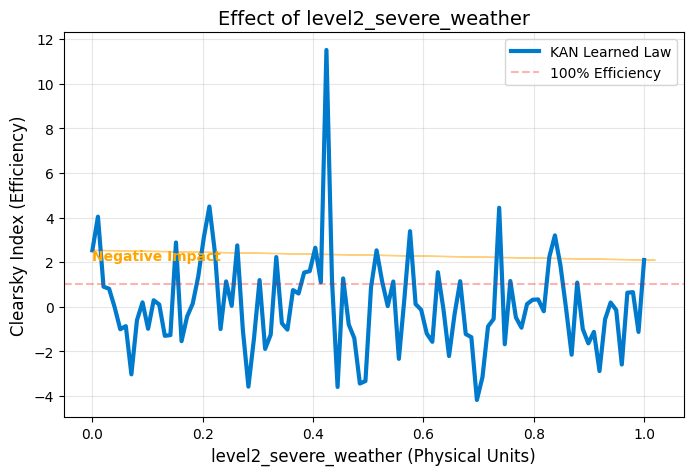

In [32]:
for feature in feature_cols:
    plot_kan_feature(model, feature, feature_cols, X_train, scaler_X)

## Visualize Individual Feature Effects

Creates plots showing how each feature affects the output through the learned Fourier transformations.

**Interpretation:**
- Smooth curves indicate Fourier series approximation
- Periodic patterns show captured daily/seasonal cycles
- Amplitude indicates feature importance

**Physical Relationships to Look For:**
- **Temperature**: Inverse relationship at high temps (efficiency loss)
- **Clear Sky GHI**: Strong positive correlation
- **Hour of day**: Parabolic pattern (sunrise-noon-sunset)
- **Humidity**: Likely negative relationship

These plots validate if FFKAN learned physically reasonable relationships.


In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# Helper Functions for Metrics Calculation
# =========================================================

def calculate_metrics_for_target(y_true, y_pred, target_name="Target"):
    """Calculate comprehensive metrics for predictions"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Normalized metrics
    capacity = y_true.max()
    if capacity == 0:
        n_mae = 0
        n_rmse = 0
    else:
        n_mae = mae / capacity
        n_rmse = rmse / capacity
    accuracy = 1 - n_mae  # Simplified accuracy metric
    
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'n_rmse': n_rmse,
        'n_mae': n_mae,
        'n_rmse_pct': n_rmse * 100,
        'n_mae_pct': n_mae * 100,
        'accuracy': accuracy
    }
    
    print(f"\n{target_name} Metrics:")
    print(f"  RMSE:    {rmse:.2f}")
    print(f"  MAE:     {mae:.2f}")
    print(f"  R²:      {r2:.4f}")
    print(f"  N-RMSE:  {n_rmse:.4f} ({n_rmse*100:.2f}%)")
    print(f"  N-MAE:   {n_mae:.4f} ({n_mae*100:.2f}%)")
    print(f"  Accuracy: {accuracy:.4f}")
    
    return metrics

def convert_to_pvw(y_pred, y_true, target_col, clearsky_values):
    """Convert predictions to PV(W) based on target column type"""
    if target_col == 'PV(W)':
        # Already in PV(W), no conversion needed
        return y_pred.copy(), y_true.copy()
    elif target_col == 'Clearsky_Index':
        # PV(W) = Clearsky_Index * Total_Power_ClearSky_Output(W)
        y_pred_pvw = y_pred * clearsky_values
        y_true_pvw = y_true * clearsky_values
    elif target_col == 'PV(W)_error':
        # PV(W) = PV(W)_error + Total_Power_ClearSky_Output(W)
        y_pred_pvw = y_pred + clearsky_values
        y_true_pvw = y_true + clearsky_values
    elif target_col == 'PV(W)_error_index':
        # PV(W) = PV(W)_error_index * Total_Power_ClearSky_Output(W) + Total_Power_ClearSky_Output(W)
        y_pred_pvw = y_pred * clearsky_values + clearsky_values
        y_true_pvw = y_true * clearsky_values + clearsky_values
    else:
        raise ValueError(f"Unknown target column: {target_col}")
    
    # Apply physics constraints (no negative power output)
    y_pred_pvw = np.clip(y_pred_pvw, 0, None)
    y_true_pvw = np.clip(y_true_pvw, 0, None)
    
    return y_pred_pvw, y_true_pvw

# =========================================================
# Get Predictions from the Model
# =========================================================

# Get predictions on test set
model.eval()
with torch.no_grad():
    test_input = dataset['test_input'].to(model.device)
    train_input = dataset['train_input'].to(model.device)
    y_pred_test_tensor = model(test_input)
    y_pred_train_tensor = model(train_input)

y_pred_test = y_pred_test_tensor.cpu().numpy()
y_pred_train = y_pred_train_tensor.cpu().numpy()

print(f"Predictions generated: test={y_pred_test.shape}, train={y_pred_train.shape}")

# =========================================================
# Extract Clearsky Values from Features
# =========================================================
# Find the index of 'Total_Power_ClearSky_Output(W)' in feature_cols
clearsky_index = feature_cols.index('Total_Power_ClearSky_Output(W)')

# Extract clearsky values from scaled features and inverse transform
clearsky_test_scaled = X_test_scaled[:, clearsky_index].reshape(-1, 1)
clearsky_train_scaled = X_train_scaled[:, clearsky_index].reshape(-1, 1)

# Create dummy arrays for inverse transform
dummy_test = np.zeros((X_test_scaled.shape[0], X_train.shape[1]))
dummy_test[:, clearsky_index] = clearsky_test_scaled.flatten()
clearsky_test = scaler_X.inverse_transform(dummy_test)[:, clearsky_index].reshape(-1, 1)

dummy_train = np.zeros((X_train_scaled.shape[0], X_train.shape[1]))
dummy_train[:, clearsky_index] = clearsky_train_scaled.flatten()
clearsky_train = scaler_X.inverse_transform(dummy_train)[:, clearsky_index].reshape(-1, 1)

print(f"Clearsky values extracted: test={clearsky_test.shape}, train={clearsky_train.shape}")

# =========================================================
# Calculate Metrics for Configured Target Column
# =========================================================
print("\n" + "="*60)
print(f"Metrics for Configured Target: {target_col}")
print("="*60)

# Apply physics constraints to predictions
y_pred_test_clipped = np.clip(y_pred_test, 0, None)
y_pred_train_clipped = np.clip(y_pred_train, 0, None)

test_metrics = calculate_metrics_for_target(y_test, y_pred_test_clipped, f"Test - {target_col}")
train_metrics = calculate_metrics_for_target(y_train, y_pred_train_clipped, f"Train - {target_col}")

# =========================================================
# Convert to PV(W) and Calculate PV(W) Metrics
# =========================================================
print("\n" + "="*60)
print("Converting to PV(W) and Calculating PV(W) Metrics")
print("="*60)

# Convert predictions and actual values to PV(W)
y_pred_test_pvw, y_test_pvw = convert_to_pvw(y_pred_test, y_test, target_col, clearsky_test)
y_pred_train_pvw, y_train_pvw = convert_to_pvw(y_pred_train, y_train, target_col, clearsky_train)

# Calculate PV(W) metrics
test_metrics_pvw = calculate_metrics_for_target(y_test_pvw, y_pred_test_pvw, "Test - PV(W)")
train_metrics_pvw = calculate_metrics_for_target(y_train_pvw, y_pred_train_pvw, "Train - PV(W)")

print("\n" + "="*60)
print("Metrics Calculation Complete")
print("="*60)

Predictions generated: test=(878, 1), train=(3508, 1)
Clearsky values extracted: test=(878, 1), train=(3508, 1)

Metrics for Configured Target: PV(W)

Test - PV(W) Metrics:
  RMSE:    2280.15
  MAE:     1808.10
  R²:      -1.6939
  N-RMSE:  0.4052 (40.52%)
  N-MAE:   0.3213 (32.13%)
  Accuracy: 0.6787

Train - PV(W) Metrics:
  RMSE:    2313.68
  MAE:     1835.73
  R²:      -1.6975
  N-RMSE:  0.4079 (40.79%)
  N-MAE:   0.3236 (32.36%)
  Accuracy: 0.6764

Converting to PV(W) and Calculating PV(W) Metrics

Test - PV(W) Metrics:
  RMSE:    2280.60
  MAE:     1808.66
  R²:      -1.6950
  N-RMSE:  0.4052 (40.52%)
  N-MAE:   0.3214 (32.14%)
  Accuracy: 0.6786

Train - PV(W) Metrics:
  RMSE:    2313.68
  MAE:     1835.75
  R²:      -1.6976
  N-RMSE:  0.4079 (40.79%)
  N-MAE:   0.3236 (32.36%)
  Accuracy: 0.6764

Metrics Calculation Complete


## Calculate Performance Metrics

Evaluates FFKAN model using comprehensive regression metrics:

**Metrics:**
1. **RMSE**: Root Mean Squared Error (penalizes large errors)
2. **MAE**: Mean Absolute Error (average error magnitude)
3. **R²**: Coefficient of determination (variance explained)
4. **N-RMSE**: Normalized RMSE (as % of range)
5. **N-MAE**: Normalized MAE (as % of range)
6. **Accuracy**: 1 - N-MAE (simplified accuracy measure)

**Two-Stage Evaluation:**
1. On configured target (e.g., Clearsky_Index)
2. Converted to PV(W) for real-world interpretation

**Model Comparison:**
These metrics enable direct comparison with:
- Standard ANN (feedforward neural network)
- KAN (B-spline based)
- FFKAN (Fourier based)

**Reference:**
- [Regression Model Evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)


In [ ]:
# =========================================================
# Save Results to CSV
# =========================================================
import os

# Define test parameters
test_no = 1  # Increment this for each test run
test_name = f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes = ""  # Add any notes about this test run

# Ensure results directory exists
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Model name
model_name = "FFKAN"

# CSV file path
csv_file = f'{results_dir}/{model_name.lower()}_test_metrics.csv'

# Prepare CSV line
with open(csv_file, 'a') as f:
    # If file is empty, write header
    if not os.path.exists(csv_file) or os.path.getsize(csv_file) == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train N-RMSE %', 'Train N-MAE %', 'Train Accuracy', 
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\\n')
    
    line = []
    line.append(model_name)
    line.append(str(test_no))
    line.append(f"{target_col}")
    line.append(f'"{test_name}"')  # Quote in case of commas
    line.append(f"{test_metrics['rmse']:.2f}")
    line.append(f"{test_metrics['mae']:.2f}")
    line.append(f"{test_metrics['r2']:.4f}")
    line.append(f"{test_metrics['n_rmse']:.4f}")
    line.append(f"{test_metrics['n_mae']:.4f}")
    line.append(f"{test_metrics['n_rmse_pct']:.4f}")
    line.append(f"{test_metrics['n_mae_pct']:.4f}")
    line.append(f"{test_metrics['accuracy']:.4f}")
    line.append(f"{train_metrics['rmse']:.2f}")
    line.append(f"{train_metrics['mae']:.2f}")
    line.append(f"{train_metrics['r2']:.4f}")
    line.append(f"{train_metrics['n_rmse']:.4f}")
    line.append(f"{train_metrics['n_mae']:.4f}")
    line.append(f"{train_metrics['n_rmse_pct']:.4f}")
    line.append(f"{train_metrics['n_mae_pct']:.4f}")
    line.append(f"{train_metrics['accuracy']:.4f}")
    line.append(f"{test_metrics_pvw['rmse']:.2f}")
    line.append(f"{test_metrics_pvw['mae']:.2f}")
    line.append(f"{test_metrics_pvw['r2']:.4f}")
    line.append(f"{test_metrics_pvw['n_rmse']:.4f}")
    line.append(f"{test_metrics_pvw['n_mae']:.4f}")
    line.append(f"{test_metrics_pvw['n_rmse_pct']:.4f}")
    line.append(f"{test_metrics_pvw['n_mae_pct']:.4f}")
    line.append(f"{test_metrics_pvw['accuracy']:.4f}")
    line.append(f"{train_metrics_pvw['rmse']:.2f}")
    line.append(f"{train_metrics_pvw['mae']:.2f}")
    line.append(f"{train_metrics_pvw['r2']:.4f}")
    line.append(f"{train_metrics_pvw['n_rmse']:.4f}")
    line.append(f"{train_metrics_pvw['n_mae']:.4f}")
    line.append(f"{train_metrics_pvw['accuracy']:.4f}")
    line.append(f"{train_metrics_pvw['n_rmse_pct']:.4f}")
    line.append(f"{train_metrics_pvw['n_mae_pct']:.4f}")
    line.append(f'"{notes}"')
    line.append(f'"feature_cols: {":".join(feature_cols)}"')
    f.write(','.join(line) + '\\n')

print(f"\\nResults saved to {csv_file}")


__Save Model__

In [ ]:
model.saveckpt(f"{MODEL_DIR}/kan_model_target.ckpt")